In this project, I have implement QR Code Authentication using Machine Learning and Deep Learning techniques. Here I have explored feature-based approaches (HOG, LBP, and Gabor filters) combined with SVM and XGBoost classifiers, as well as a CNN-based deep learning model to classify QR codes as original or counterfeit.

In [1]:
!pip install opencv-python  PyWavelets py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 38.1 MB/s eta 0:00:00


Import Required libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import pywt
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


Loading the dataset

In [2]:
dataset_path = "/content/drive/MyDrive/Assignment Data"

In [3]:
# Load images
def load_images(folder):
    images = []
    labels = []
    for label in ["First Print", "Second Print"]:
        path = os.path.join(folder, label)
        for file in tqdm(os.listdir(path), desc=f"Loading {label}"):
            img = cv2.imread(os.path.join(path, file), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (256, 256))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

Two files, First print and second print files are merged together along with its labels

In [4]:
images, labels = load_images(dataset_path)

Loading Second Print: 100%|██████████| 100/100 [00:02<00:00, 35.78it/s]


In [5]:
print(len(images))
print(len(labels))

200
200


In [6]:
unique, counts = np.unique(labels, return_counts=True)

for label, count in zip(unique, counts):
    print(f"{label}: {count} samples")

First Print: 100 samples
Second Print: 100 samples


Label encoding the labels

In [7]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

Normalization of Image Data

In [8]:
images = images / 255.0

Splitting data for model training

In [10]:
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

Visualizing Sample Images from the Training Set

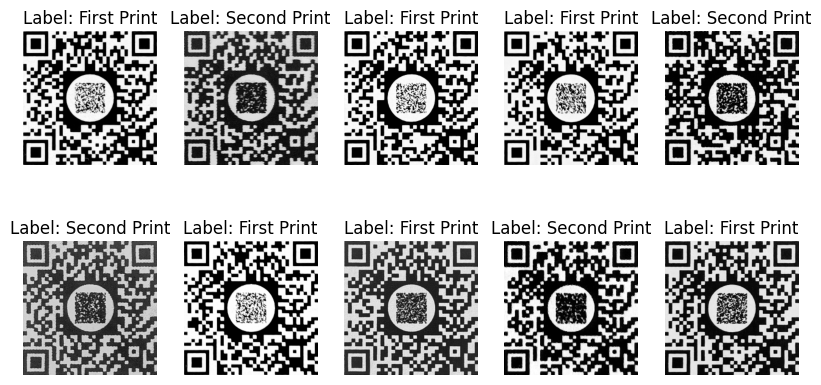

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Label: {label_encoder.inverse_transform([y_train[i]])[0]}")
    ax.axis('off')
plt.show()


Extracting image features using HOG (gradient-based features), LBP (texture-based features), and Gabor filters (frequency-based features) for classification.

In [14]:
# Feature Extraction
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor

def extract_hog_features(images):
    return np.array([hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True) for img in images])

def extract_lbp_features(images):
    return np.array([local_binary_pattern(img, P=24, R=3).flatten() for img in images])

def extract_gabor_features(images):
    return np.array([gabor(img, frequency=0.6)[0].flatten() for img in images])

In [15]:
hog_features_train = extract_hog_features(X_train)
lbp_features_train = extract_lbp_features(X_train)
gabor_features_train = extract_gabor_features(X_train)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


 Standardizing the extracted HOG, LBP, and Gabor features to ensure uniform scaling.

In [16]:
# Standardize features
scaler = StandardScaler()

hog_features_train = scaler.fit_transform(hog_features_train)
lbp_features_train = scaler.fit_transform(lbp_features_train)
gabor_features_train = scaler.fit_transform(gabor_features_train)

Comparing the distributions of the mean values of HOG, LBP, and Gabor features.

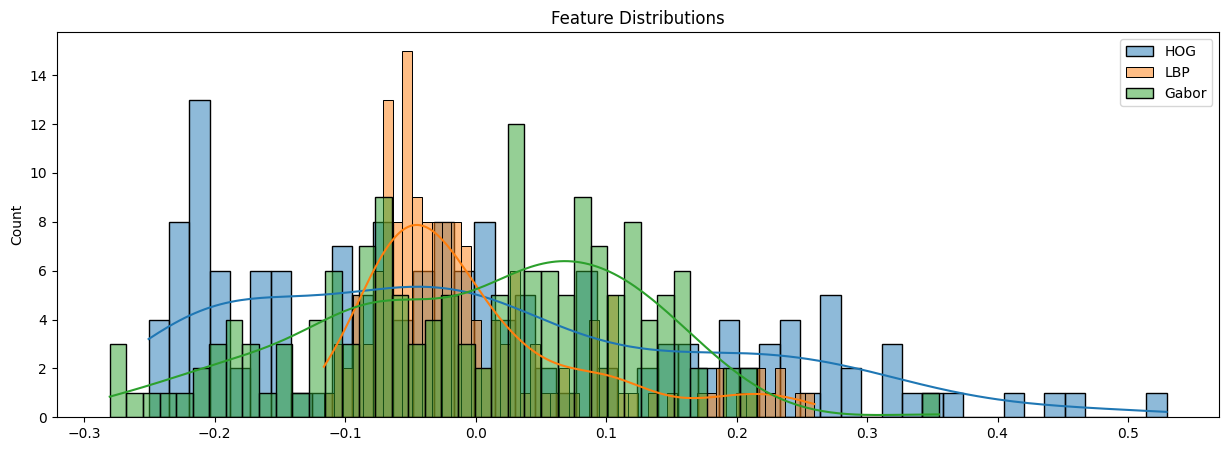

In [17]:
plt.figure(figsize=(15, 5))
sns.histplot(hog_features_train.mean(axis=1), bins=50, kde=True, label="HOG")
sns.histplot(lbp_features_train.mean(axis=1), bins=50, kde=True, label="LBP")
sns.histplot(gabor_features_train.mean(axis=1), bins=50, kde=True, label="Gabor")
plt.legend()
plt.title("Feature Distributions")
plt.show()

Take aways from the distribution:

HOG features are more spread out with a wider distribution, peaking around -0.2.

LBP features are more concentrated, with a sharp peak near -0.1.

Gabor features have a more uniform spread across the range, peaking around 0.05.

Similar steps for test dataset:

In [18]:
hog_features_test = extract_hog_features(X_test)
lbp_features_test = extract_lbp_features(X_test)
gabor_features_test = extract_gabor_features(X_test)

/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [19]:
hog_features_test = scaler.fit_transform(hog_features_test)
lbp_features_test = scaler.fit_transform(lbp_features_test)
gabor_features_test = scaler.fit_transform(gabor_features_test)

Stacking both training and test features

In [20]:
X_train_features = np.hstack([hog_features_train, lbp_features_train, gabor_features_train])
X_test_features = np.hstack([hog_features_test, lbp_features_test, gabor_features_test])


In [23]:
print("X_train_features", X_train_features.shape)
print("X_test_features:", X_test_features.shape)


X_train_features (160, 165668)
X_test_features: (40, 165668)


Implemeting SVM and fitting the x train and y train

In [21]:
from sklearn import svm
# Train SVM Model
clf = svm.SVC(kernel='linear')
clf.fit(X_train_features, y_train)

SVC(kernel='linear')

Prediction and Evaluation

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test_features)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred))

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        19

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



The SVM Classification Report shows that the model achieved perfect performance on the test dataset:

Precision (1.00): All predicted labels are correct.

Recall (1.00): The model correctly identifies all instances of both classes.

F1-score (1.00): The harmonic mean of precision and recall is perfect.

Accuracy (1.00): The model classified all 40 test samples correctly.

In [71]:
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

SVM Confusion Matrix:
[[20  0]
 [ 0 20]]


Lets try with XGBoost

In [72]:
from xgboost import XGBClassifier

# XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train_features, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [73]:
y_pred_xgb = xgb_model.predict(X_test_features)

In [74]:
# Evaluate XGBoost model
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [75]:
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Confusion Matrix:
[[19  1]
 [ 0 20]]


The XGBoost Classification Report and Confusion Matrix indicate that the model performs exceptionally well but with a slight drop in accuracy compared to SVM:

Precision: 1.00 for  First Print and 0.95 for  Second Print

Recall: 0.95 for First Print and 1.00 for Second Print

F1-score: 0.97 and 0.98, indicating strong balance between precision and recall

Overall Accuracy: 97%

CNN BASED APPROACH

reshaping the image dataset to be compatible with CNN.

In [64]:
X_train_cnn = X_train.reshape(-1, 256, 256, 1)
X_test_cnn = X_test.reshape(-1, 256, 256, 1)

one-hot encode the target labels for training.

In [66]:
from tensorflow.keras.utils import to_categorical
y_train_cnn = to_categorical(y_train, num_classes=2)
y_test_cnn = to_categorical(y_test, num_classes=2)

building and compiling a CNN for binary classification:

 It consists of three convolutional layers with ReLU activation and max pooling for feature extraction, followed by fully connected layers with dropout to prevent overfitting. The final layer uses softmax activation for classification. The model is compiled with Adam optimizer and categorical cross-entropy loss for training.

In [33]:
# CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [34]:
cnn_model = build_cnn_model()
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,838,658 (56.60 MB)

 Trainable params: 14,838,658 (56.60 MB)

 Non-trainable params: 0 (0.00 B)

This CNN architecture consists of three convolutional layers with increasing filters (32, 64, 128), followed by max pooling to reduce spatial dimensions. After flattening, a fully connected layer with 128 neurons processes features, with dropout (0.5) to prevent overfitting. The final softmax layer classifies images into two categories. The model has 14.8M trainable parameters.

fitting the model

In [36]:
cnn_history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=16, validation_data=(X_test_cnn, y_test_cnn))

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5479 - loss: 1.3071 - val_accuracy: 0.5000 - val_loss: 0.7003
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5407 - loss: 0.6966 - val_accuracy: 0.7500 - val_loss: 0.6700
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7126 - loss: 0.6566 - val_accuracy: 0.8250 - val_loss: 0.5593
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7433 - loss: 0.5643 - val_accuracy: 0.8250 - val_loss: 0.5683
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8151 - loss: 0.5238 - val_accuracy: 0.9250 - val_loss: 0.4035
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9103 - loss: 0.3278 - val_accuracy: 0.8750 - val_loss: 0.2599
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9634 - loss: 0.1788 - val_accuracy: 0.8000 - val_loss: 0.7109
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9321 - loss: 0.2538 - val_accuracy: 0.9250 - val_loss:

Prediction and reporting

In [39]:
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 488ms/step
CNN Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



In [38]:
print("CNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cnn))

CNN Confusion Matrix:
[[19  1]
 [ 1 19]]


The CNN model achieved 95% accuracy, with precision, recall, and F1-score of 0.95 for both classes. The confusion matrix shows that only two misclassifications occurred (one from each class)

Key Takeaway:
SVM outperformed both XGBoost and CNN, indicating that handcrafted features were highly effective for QR code authentication.